In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import psycopg2

## Grab static data

In [4]:
conn = psycopg2.connect(host='localhost',dbname='postgres',user='postgres',password='postgres')
static = pd.read_sql_query(
    """
    SELECT * FROM mimic_derived.sepsis3_static_24hours
    """,
    con=conn
)
# We can remove sepsis3 as all are TRUE
static.drop('sepsis3', axis=1, inplace=True)
# We can drop duplicate subject_ids and only keep the first stay in the icu: explained later below
# Gender is expressed as an object, but there are 2 distinct values in the whole dataset, we can express this as categorical
static.gender = static.gender.astype('category')
#dod is expressed as an object but we know this is a date, as specified in the DDL of the table in postgres. There are a huge number of missing values for this, as we know that absence of death means that a patient did not die, but was still discharged. I think a sensible alternative is to drop this column and instead use hospital_expire_flag. This is a binary flag which indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge. One point of confusion is the difference in number of hospital expire flags = , and the number of date of deaths. My suspicion is that people can only die once, and so potentially a patient who had multiple stays and ultimately died would have multiple dates of death, and only one hospital expire flag. This can be confirmed by only considering individuals on their first icu stay of their first hospital stay, which has the added bonus of being in agreement with one of the assumptions of logistic regression - that is to say that the observations are independent of each other and not coming from repeated or paired data. Hospital expire flag can be used in conjunction with the discharge date to confirm the dod. I will need to confirm this by comparing the count of the number of patients with the count of the number of patients on their first icu stay of their first hospital stay - they should be the same.
static.sort_values(by=['subject_id','hospstay_seq','icustay_seq'], inplace=True)
static = static.groupby('subject_id', as_index=False).first()
# ethnicity can be made categorical. Can confirm there are 8 categories with significant numbers for each. Note: there are three categories: other, unknown and unable to obtain, with 0 missing. I think unknown and unable to obtain should be dropped, and other kept. Unknown and unable to obtain can be merged.
static.loc[static['ethnicity'] == 'UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN'
static.ethnicity = static.ethnicity.astype('category')
# It would be good to express the antibiotic time, culture time, suspected infection time, and sofa time as time elapsed since admission to hospital, rather than a datetime.
# We should just be able to subtract the admittime
# Antibiotic, culture, suspected infection and sofa are all expressed as datetime64[ns]
# icu intime is the same
# Infection related times
static.antibiotic_time = (static.antibiotic_time - static.admittime).astype("timedelta64[h]")
static.culture_time = (static.culture_time - static.admittime).astype("timedelta64[h]")
static.suspected_infection_time = (static.suspected_infection_time - static.admittime).astype("timedelta64[h]")
static.sofa_time = (static.sofa_time - static.admittime).astype("timedelta64[h]")
# Admission to ICU and discharge
static.dischtime = (static.dischtime - static.admittime).astype("timedelta64[h]")
static.icu_intime = (static.icu_intime - static.admittime).astype("timedelta64[h]")
static.icu_outtime = (static.icu_outtime - static.admittime).astype("timedelta64[h]")
# Add mortality column
static['Died'] = static['hospital_expire_flag'].apply(lambda x: True if x == 1 else False)

<built-in function getcwd>


C:\Users\gq19765\Anaconda3\envs\Precision_antimicrobial_pres\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
# Drop irrelevant columns
all_columns = list(static.columns)
drop_columns = ['subject_id','stay_id','antibiotic_time','culture_time','suspected_infection_time','sofa_time','hadm_id','dod','admittime','dischtime','los_hospital','hospital_expire_flag','first_hosp_stay','icu_intime','icu_outtime','los_icu','first_icu_stay']
static = static[static.columns.difference(drop_columns)]

### Encode text columns
#### Ethnicity

In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(static[['ethnicity']])
static[ohe.categories_[0]] = transformed.toarray()
static = static.drop(['ethnicity'], axis=1)
for column in static.columns:
    print (column)

Died
abs_basophils_max
abs_basophils_min
abs_eosinophils_max
abs_eosinophils_min
abs_lymphocytes_max
abs_lymphocytes_min
abs_monocytes_max
abs_monocytes_min
abs_neutrophils_max
abs_neutrophils_min
admission_age
albumin_max
albumin_min
alp_max
alp_min
alt_max
alt_min
amylase_max
amylase_min
aniongap_max
aniongap_min
ast_max
ast_min
atyps_max
atyps_min
bands_max
bands_min
bicarbonate_max
bicarbonate_min
bilirubin_direct_max
bilirubin_direct_min
bilirubin_indirect_max
bilirubin_indirect_min
bilirubin_total_max
bilirubin_total_min
bun_max
bun_min
calcium_max
calcium_min
cardiovascular
chloride_max
chloride_min
ck_cpk_max
ck_cpk_min
ck_mb_max
ck_mb_min
cns
coagulation
creatinine_max
creatinine_min
d_dimer_max
d_dimer_min
dbp_max
dbp_mean
dbp_min
fibrinogen_max
fibrinogen_min
gender
ggt_max
ggt_min
globulin_max
globulin_min
glucose_max
glucose_mean
glucose_min
heart_rate_max
heart_rate_mean
heart_rate_min
hematocrit_max
hematocrit_min
hemoglobin_max
hemoglobin_min
hospstay_seq
icustay_seq
im

#### Gender
- Female = 1
- Male = 0

In [7]:
static['gender'] = static['gender'].apply(lambda x: 1 if x == 'F' else 0).astype(int)

### Encode target label (Died/Survived)

In [8]:
static['Died'] = static['Died'].astype(int)

### Features

In [32]:
X = static.iloc[:,1:]

### Label

In [33]:
y = static.iloc[:,0]

### Scale
#### Standard Scaler

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)

## KNN Imputation

In [35]:
from sklearn.impute import KNNImputer

before_imputation = X
imputer = KNNImputer(n_neighbors=2)
after_imputation = imputer.fit_transform(before_imputation)

# PCA

In [39]:
pca = PCA(n_components=0.95)
pca.fit(after_imputation)
reduced = pca.transform(after_imputation)

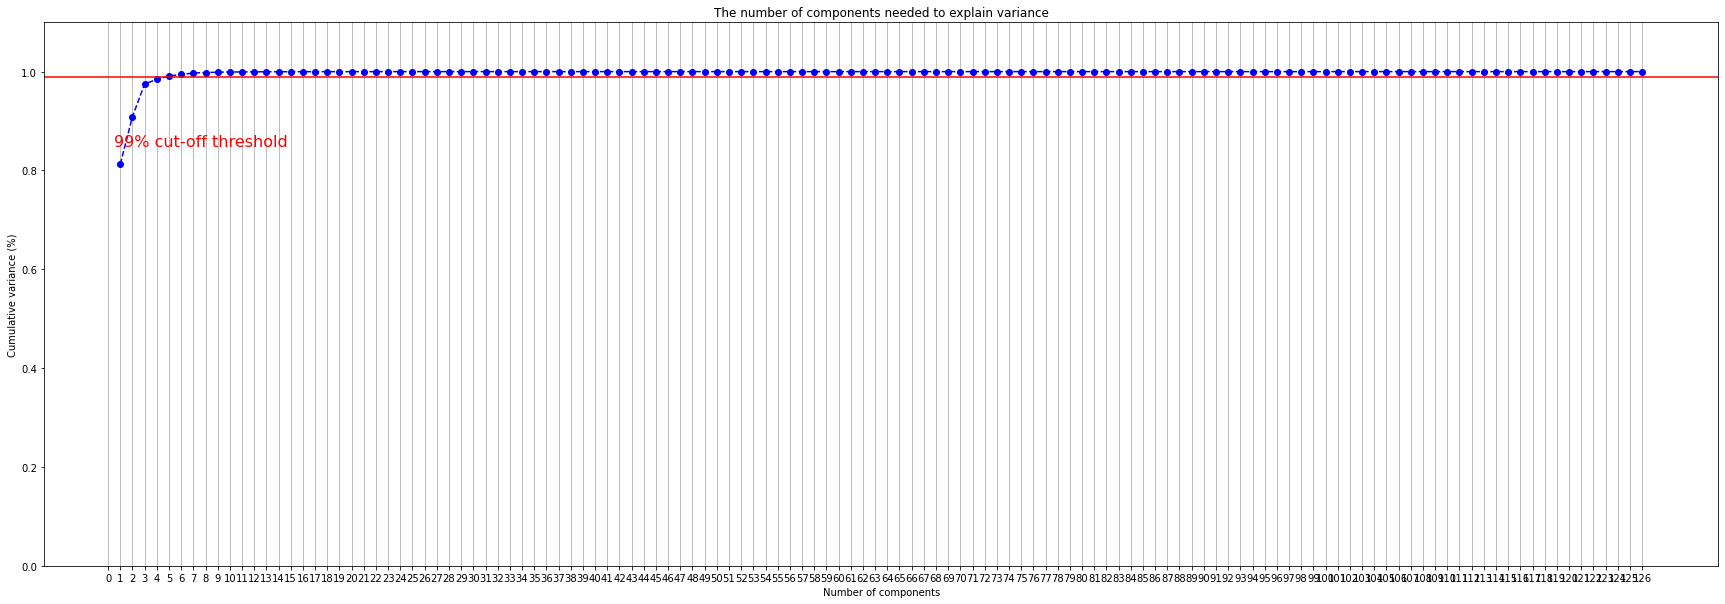

In [45]:
pca = PCA().fit(after_imputation)

plt.rcParams["figure.figsize"] = (30,10)

fig, ax = plt.subplots()
xi = np.arange(1,127,step=1)
y2 = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi,y2,marker='o',linestyle='--',color='b')

plt.xlabel('Number of components')
plt.xticks(np.arange(0,127,step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99,color='r',linestyle='-')
plt.text(0.5,0.85, '99% cut-off threshold',color='red',fontsize=16)

ax.grid(axis='x')
plt.show()

In [46]:
pca = PCA(n_components=5)
pca.fit(after_imputation)
reduced = pca.transform(after_imputation)

In [47]:
print(reduced.shape)

(27139, 5)


In [48]:
pca.components_

array([[-2.61747459e-07, -7.46474796e-07, -8.58152828e-07,
        -1.24065839e-06, -1.41486650e-05, -1.43777592e-05,
         1.28595146e-05,  1.12948944e-06,  8.21565342e-06,
        -3.63577577e-05, -1.19707786e-05,  8.34911905e-08,
         6.65155686e-08,  1.21414151e-04,  9.84165765e-05,
         1.18149858e-03,  5.01247464e-04, -5.04730889e-05,
        -4.18233240e-05,  3.65162862e-06,  2.42153249e-06,
         2.57522724e-03,  1.55265543e-03, -6.15295932e-09,
        -5.84509329e-09,  2.62807471e-07,  1.29607743e-06,
        -2.42189743e-06, -3.27883658e-06,  1.45546755e-06,
         1.40631137e-06,  1.51065752e-06,  1.57769662e-06,
         9.37814630e-06,  8.22977559e-06,  1.06706858e-05,
         7.88440409e-06,  9.88502964e-09, -7.70752019e-10,
        -1.17901792e-07, -1.52791270e-06, -2.09501879e-06,
        -9.43143158e-04, -4.48630661e-04, -5.74599506e-06,
        -1.73491434e-06, -2.06116789e-07,  4.62353959e-07,
         6.11701967e-07,  2.43173396e-07,  3.26779153e-0

### Plot components
#### 2 principle components

Text(0, 0.5, 'pc2')

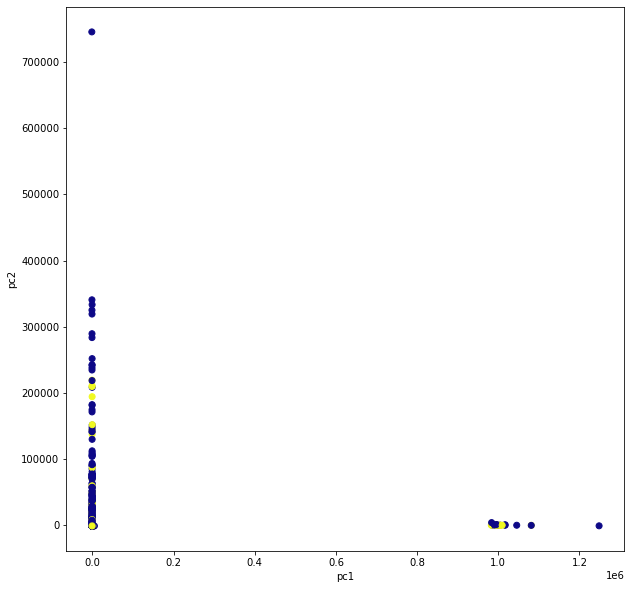

In [52]:
plt.figure(figsize=(10,10))
plt.scatter(reduced[:,0],reduced[:,1],c=y,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

#### 3 principle components

Text(0.5, 0, 'PC3')

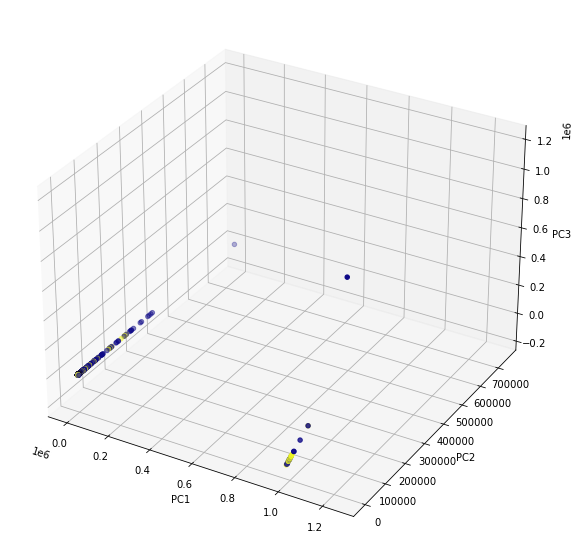

In [53]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')

# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(reduced[:,0],reduced[:,1],reduced[:,2], c=y,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

### Calculate variance ratio

In [55]:
print(pca.explained_variance_ratio_)

[0.81279677 0.09621064 0.06595862 0.00927229 0.00683356]


# Logistic Regression

In [56]:
X_pca = pd.DataFrame(reduced)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca,y, test_size=0.3, random_state=100, stratify=y)

In [58]:
df = pd.DataFrame(y)
print(df.value_counts())

Died
0       22852
1        4287
dtype: int64


In [59]:
# Seeing the split across training and testing datasets
print('Number of records in the original dataset: ', len(y))
print('Number of records in the training dataset: ', len(y_train))
print('Number of records in the testing dataset: ', len(y_test))

Number of records in the original dataset:  27139
Number of records in the training dataset:  18997
Number of records in the testing dataset:  8142


## Train the model

In [60]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

C:\Users\gq19765\Anaconda3\envs\Precision_antimicrobial_pres\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Predict

In [61]:
y_pred = log_reg.predict(X_test)

## Performance

In [62]:
score = log_reg.score(X_test, y_test)
print(score)

0.8420535494964382


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)

[[6844   12]
 [1274   12]]


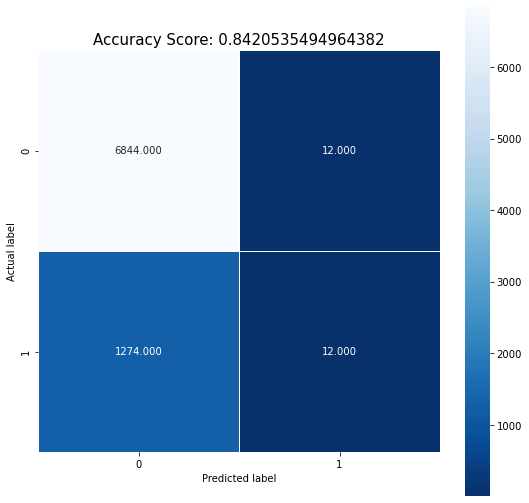

In [64]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## ROC Curve

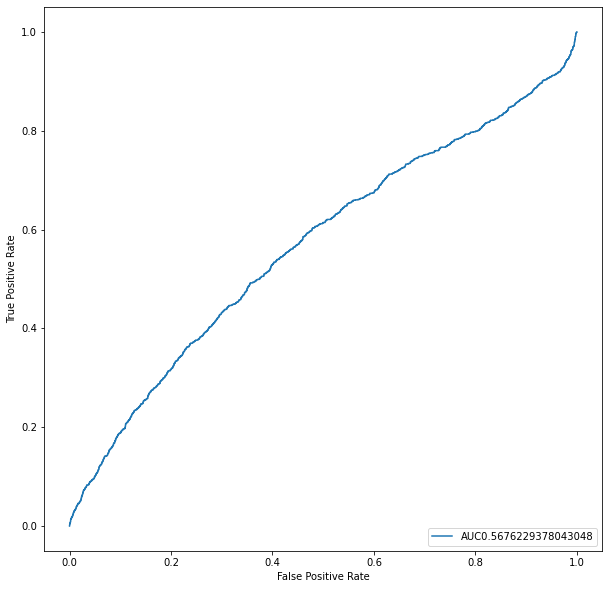

In [66]:
from sklearn.metrics import roc_curve
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr,tpr,_ = roc_curve(y_test,y_pred_proba)
auc = metrics.roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label="AUC"+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()